In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from obspy import read
from obspy.core import UTCDateTime
from obspy.core.stream import Stream
from SeismicData import SeismicData

In [2]:
#root_folder = "data20180703ext"
#root_folder = "data20180703"
root_folder = "data20180505"
ud01_data_folder_path = root_folder+"/UD01"
ud02_data_folder_path = root_folder+"/UD02"
ud03_data_folder_path = root_folder+"/UD03"
ud04_data_folder_path = root_folder+"/UD04"

directions_data_folders = ["6d97e2", "6d97n2", "6d97z2"]

In [3]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
def square_sum (seismic_data):
    square_sum = list()
    for i, time in enumerate(seismic_data.times):
        summ = np.float64(0)
        for trace in seismic_data.traces:
            summ+=trace[i]*trace[i]
        summ /= seismic_data.alive_traces_count[i]
        square_sum.append((time, summ))
    return square_sum


In [5]:
def plot(x, y):    
    from matplotlib import pyplot as plt
    plt.figure(figsize=(30,10))
    plt.plot(x,y)
    plt.show()

In [6]:
min_filtering_frequency = 0.1
max_filtering_frequency = 30

def process_station_data(station_data_folder):
    import os 
    station_data = Stream()
    for direction in directions_data_folders:
        direction_stream = Stream()
        data_folder = station_data_folder+"/"+direction
        for filename in os.listdir(data_folder):
            input_stream=read(data_folder+"/"+filename)
            direction_stream += input_stream
        direction_stream.merge(fill_value=0)
        station_data+=direction_stream
    return station_data

In [7]:
%%time
station_data = process_station_data(ud01_data_folder_path)
station_data += process_station_data(ud02_data_folder_path)
station_data += process_station_data(ud03_data_folder_path)
station_data += process_station_data(ud04_data_folder_path)

Wall time: 12.2 s


In [8]:
station_data = station_data.detrend()
station_data = station_data.filter("bandpass", freqmin=min_filtering_frequency,freqmax = max_filtering_frequency)

C:\ProgramData\Anaconda3\lib\site-packages\obspy\signal\detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


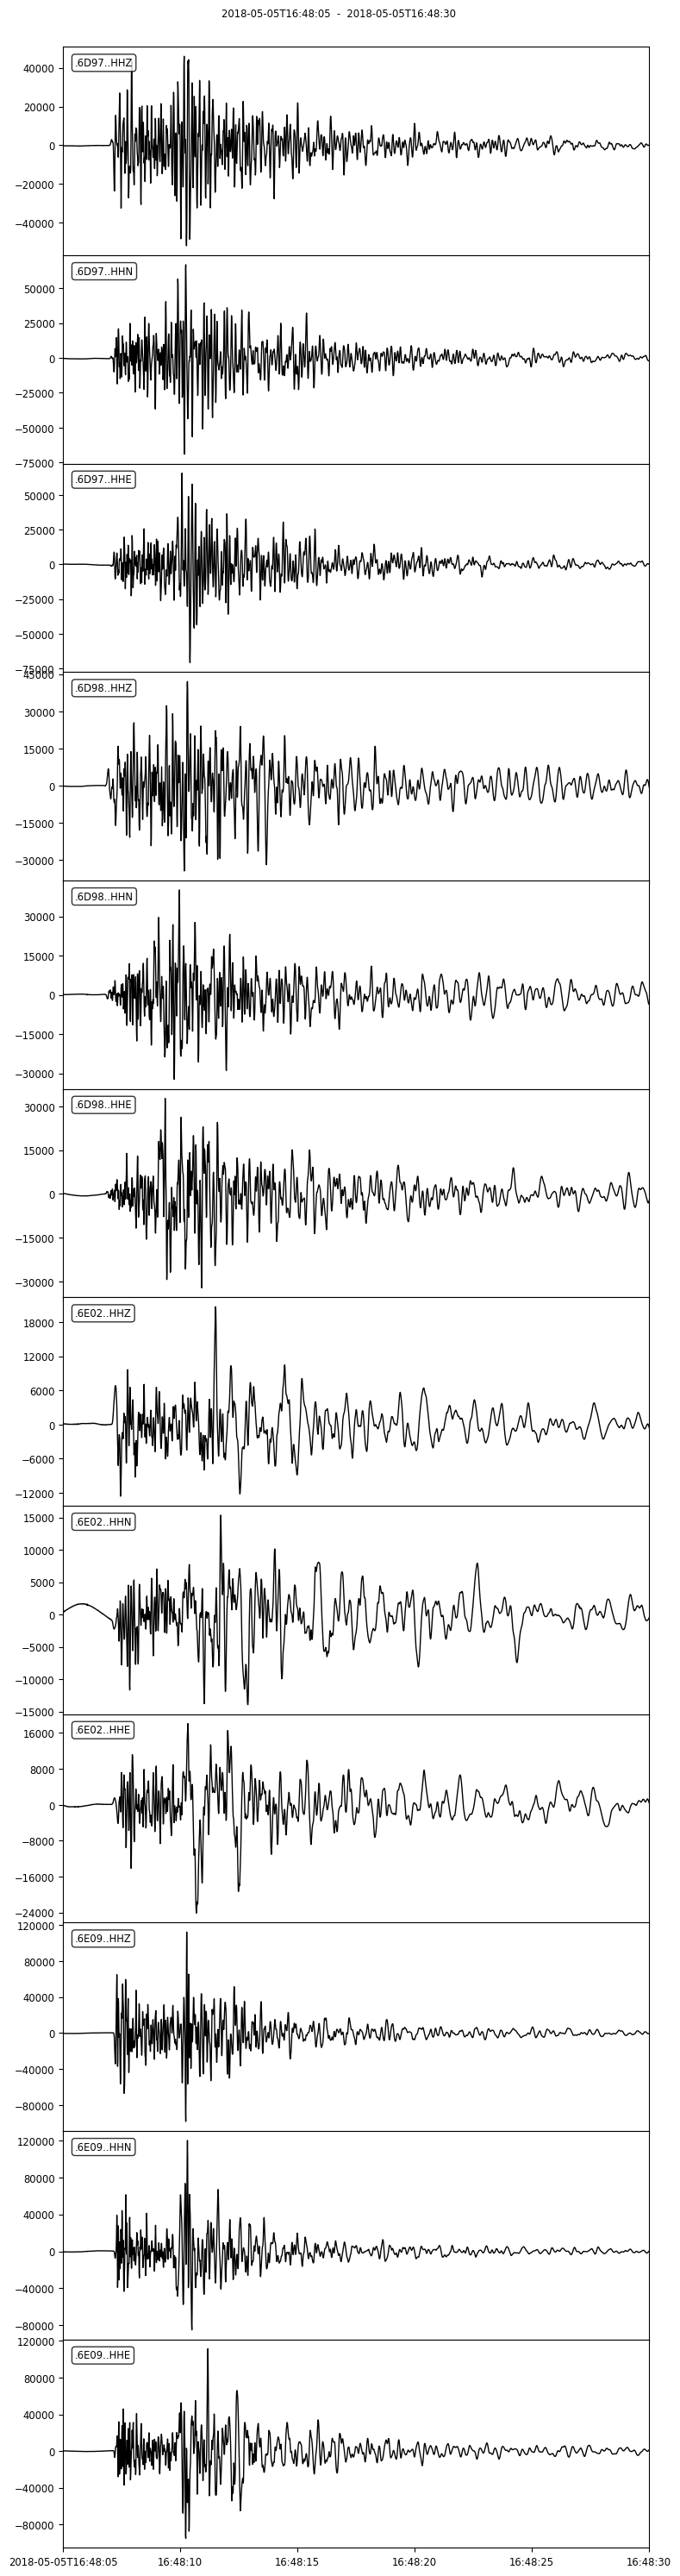

In [51]:
station_data.plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T16:48:05'), endtime=UTCDateTime('2018-05-05T16:48:30'))

In [ ]:
processed_station_data.plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T16:47:30'), endtime=UTCDateTime('2018-05-05T16:49:00'))

In [9]:
%%time
seismic_data = SeismicData(station_data)

Station data preprocessing...
max trace = .6D97..HHE | 2018-05-05T05:00:00.000000Z - 2018-05-05T23:59:59.990000Z | 100.0 Hz, 6840000 samples
max trace times = [UTCDateTime(2018, 5, 5, 5, 0) UTCDateTime(2018, 5, 5, 5, 0, 0, 10000)
 UTCDateTime(2018, 5, 5, 5, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 5, 23, 59, 59, 970000)
 UTCDateTime(2018, 5, 5, 23, 59, 59, 980000)
 UTCDateTime(2018, 5, 5, 23, 59, 59, 990000)]
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessi

In [10]:
%%time
squareSum = square_sum(seismic_data)

Wall time: 1min 39s


откуда такие файлы


In [11]:
x = list()
y = list()

for item in squareSum:
    x.append(item[0])
    y.append(item[1])


In [12]:
m=2250

In [13]:
y_av = moving_average(y.copy(), m)

In [14]:
x_av = x[:len(y_av)]

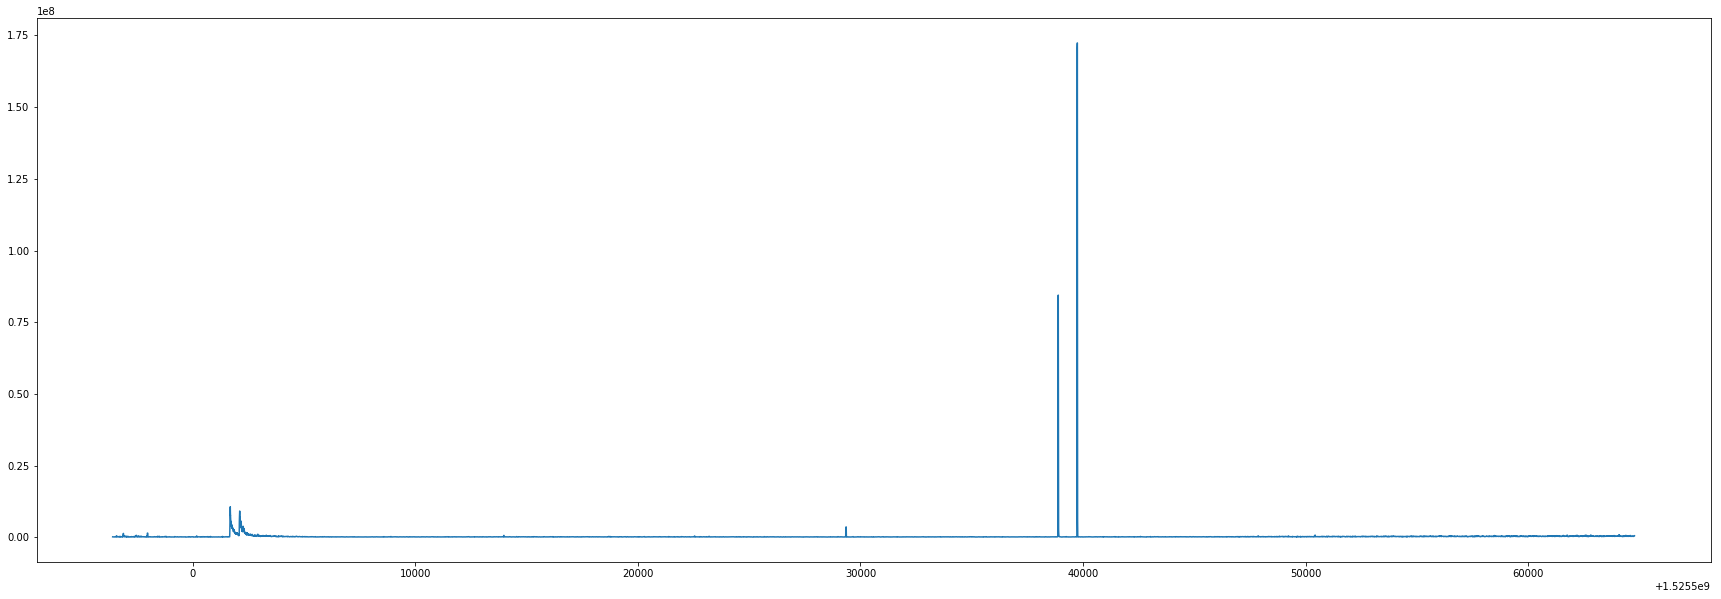

In [77]:
plot(x_av, y_av)

In [15]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(y_av, height=0.08e8)
print('len peaks = {}'.format(len(peaks)))

len peaks = 9


In [78]:
lpeaks = np.asarray(peaks)
x_av = np.asarray(x_av)

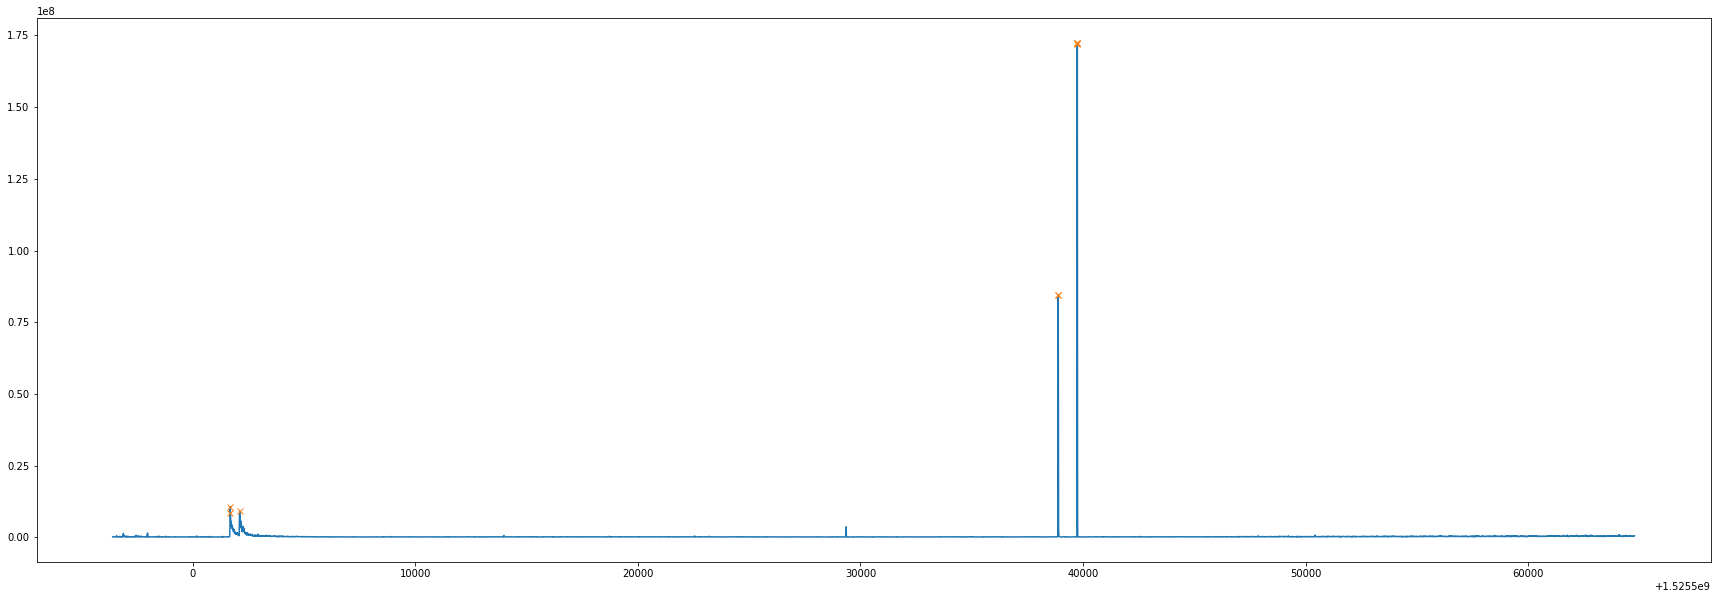

In [76]:
from matplotlib import pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(x_av,y_av)
plt.plot(x_av[lpeaks], y_av[lpeaks], "x")
plt.show()

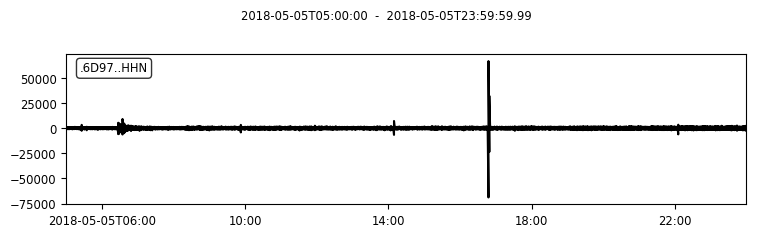

In [18]:
t = station_data[1]
t.plot()

In [20]:
times = t.times("matplotlib")

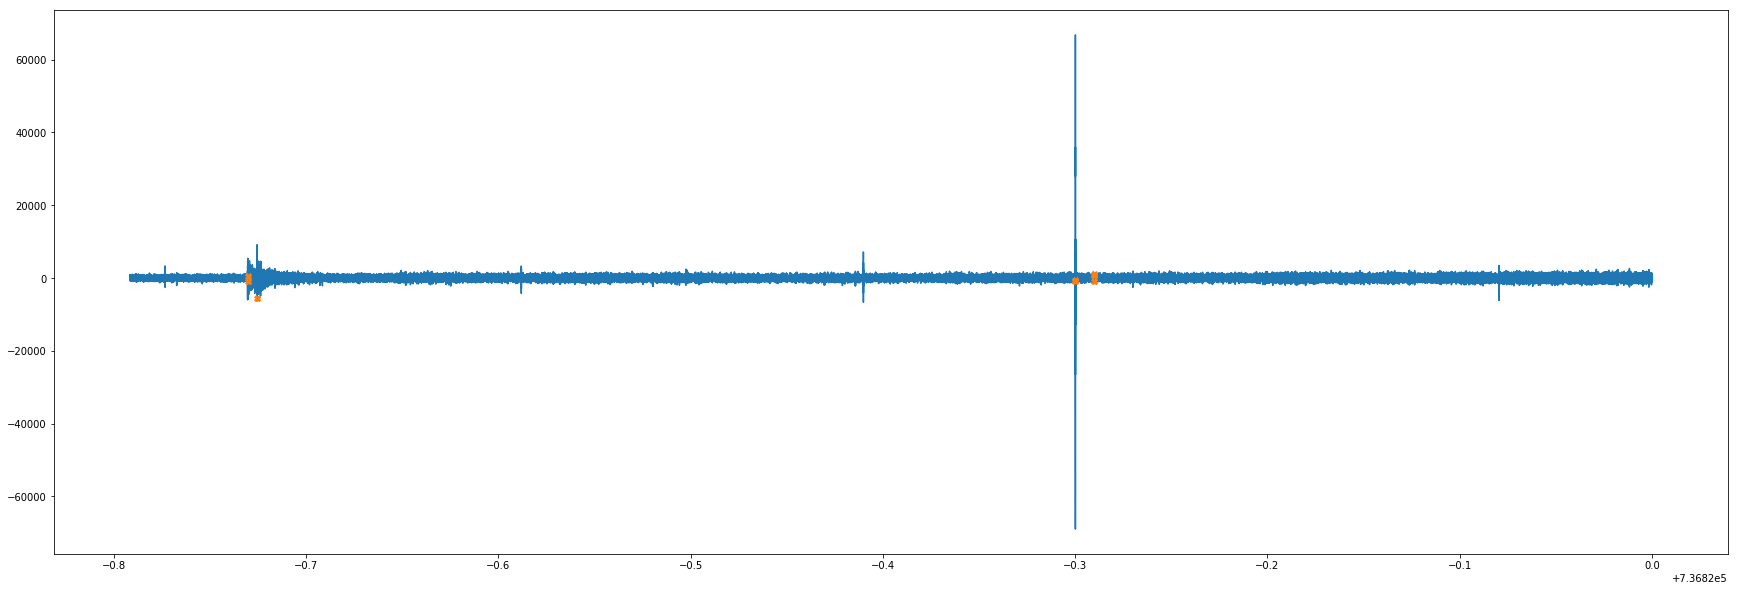

In [74]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(times, t.data)
ax.plot(times[lpeaks], t.data[lpeaks], "X")
plt.show()

In [92]:
t1 = station_data[0]
t1_data = t1.data
t1_times = t1.times("utcdatetime")
starttime=UTCDateTime('2018-05-05T16:48:05')
endtime=UTCDateTime('2018-05-05T16:48:30')
ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)
indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

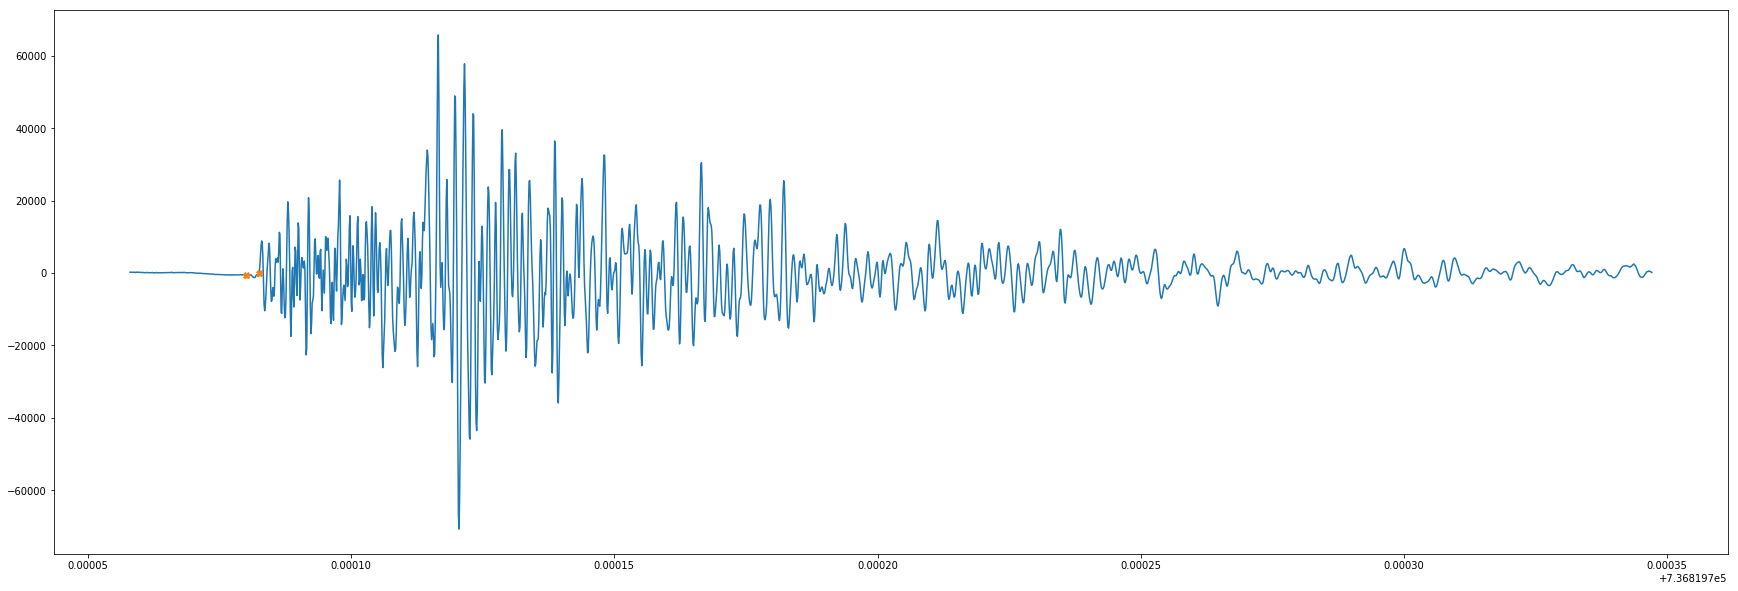

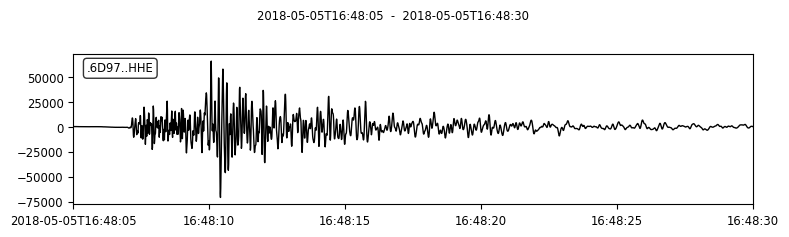

In [139]:
station_data[0].plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T16:48:05'), endtime=UTCDateTime('2018-05-05T16:48:30'))

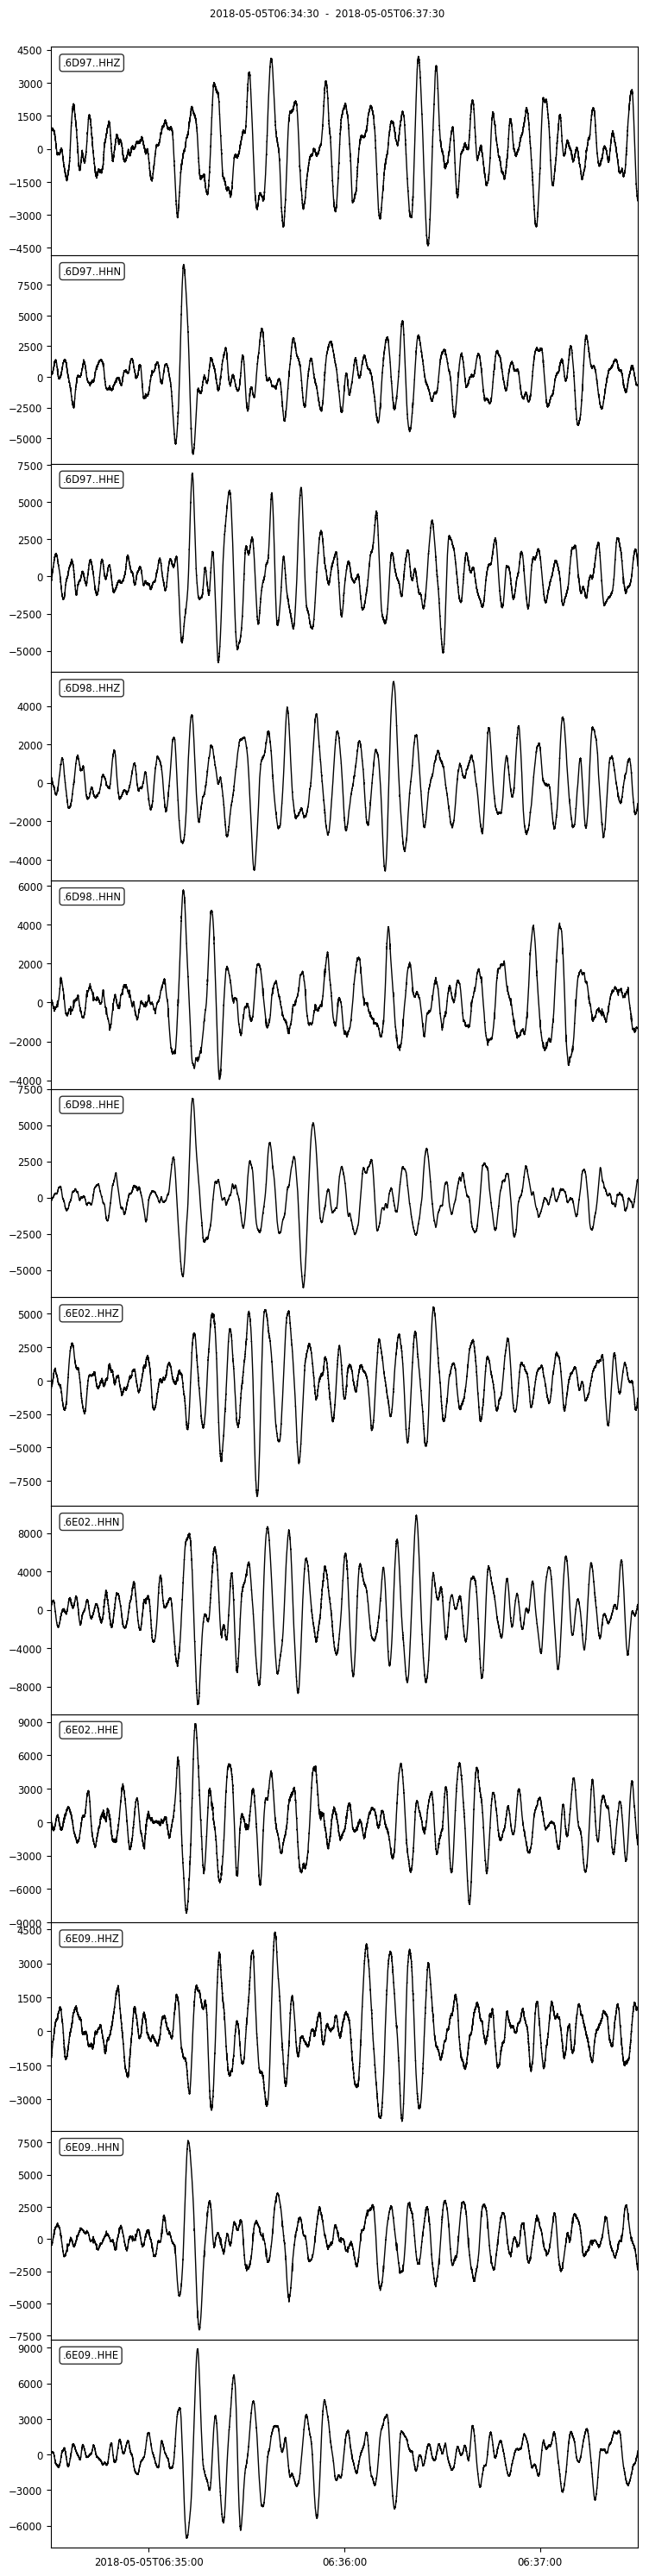

In [147]:
station_data.plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T06:34:30'), endtime=UTCDateTime('2018-05-05T06:37:30'))

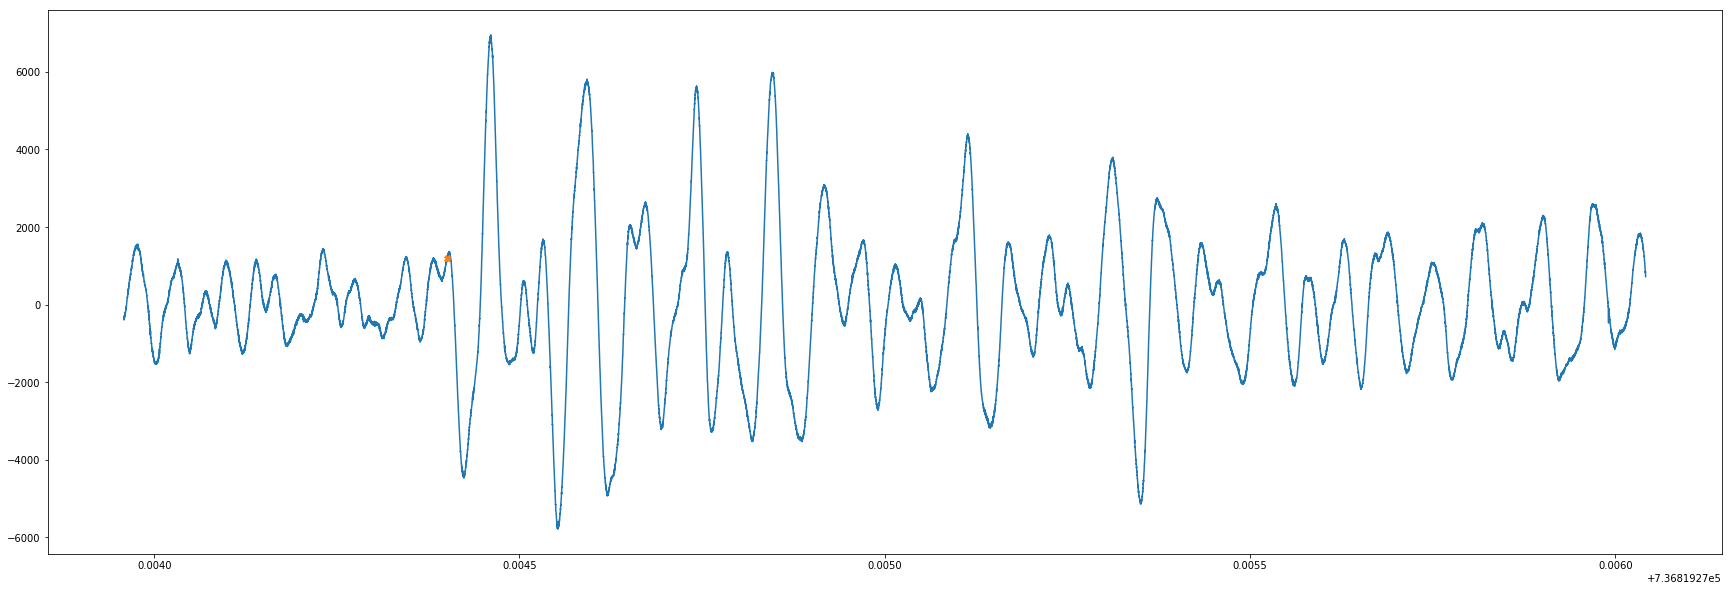

In [148]:
t1 = station_data[0]
t1_data = t1.data
t1_times = t1.times("utcdatetime")
starttime=UTCDateTime('2018-05-05T06:34:30')
endtime=UTCDateTime('2018-05-05T06:37:30')
ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)
indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()

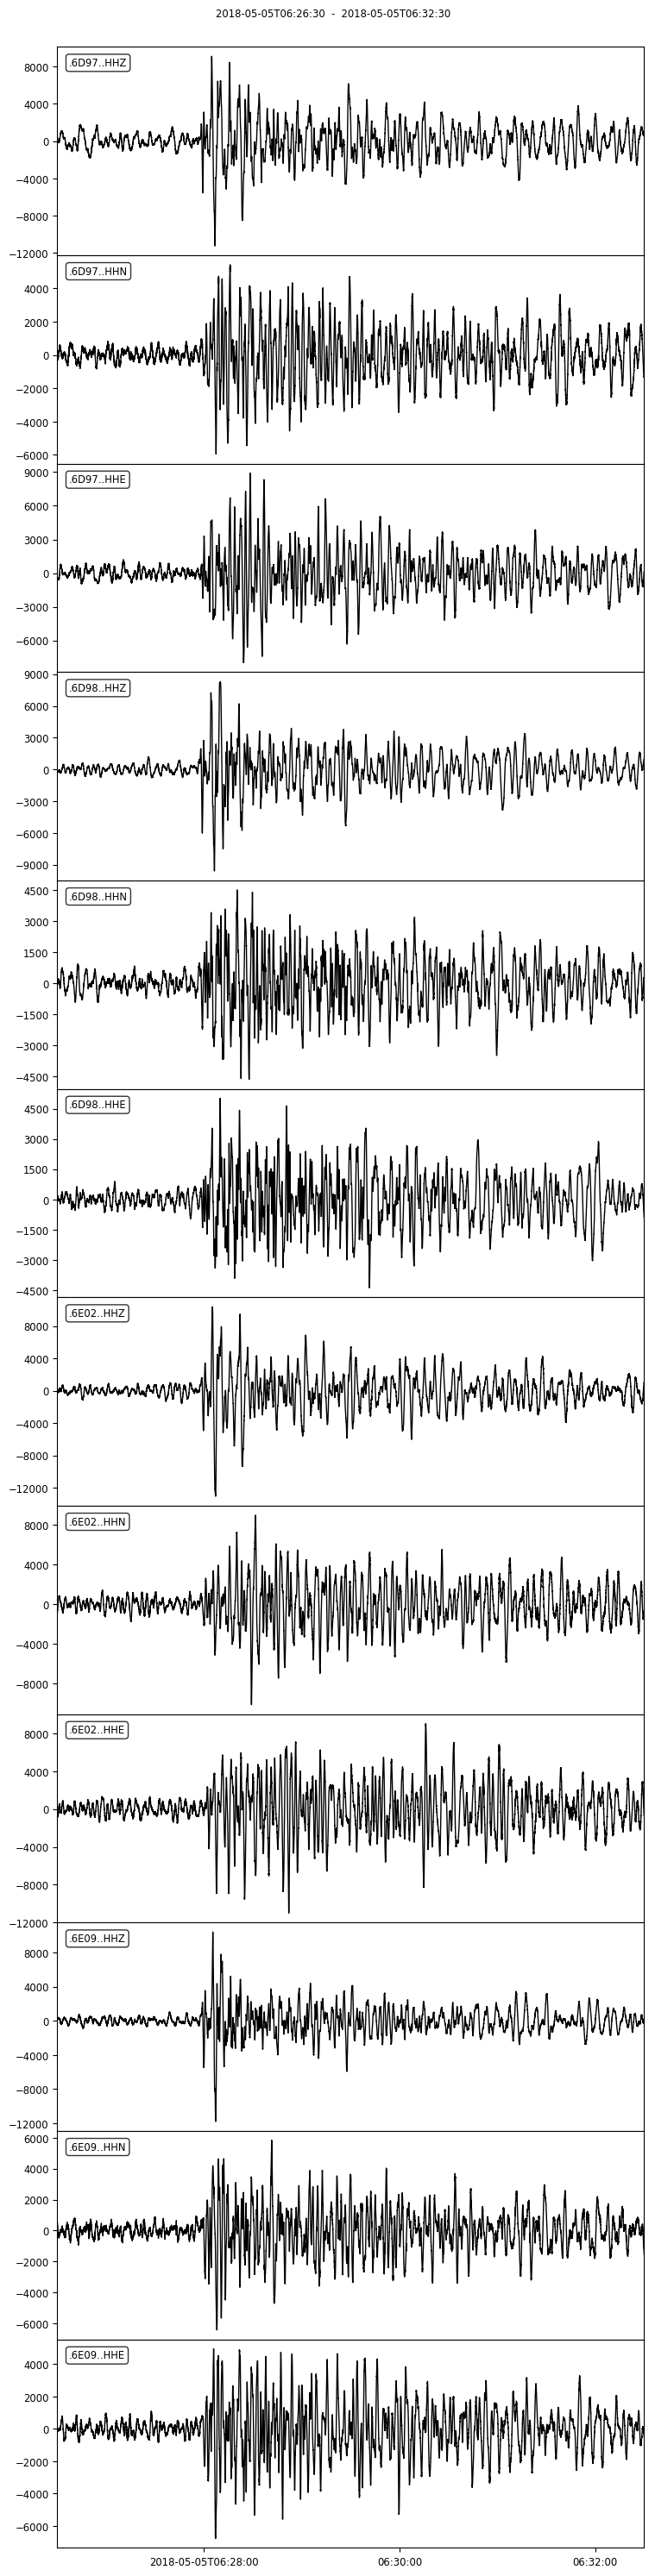

In [152]:
station_data.plot(equal_scale=False, starttime=UTCDateTime('2018-05-05T06:26:30'), endtime=UTCDateTime('2018-05-05T06:32:30'))

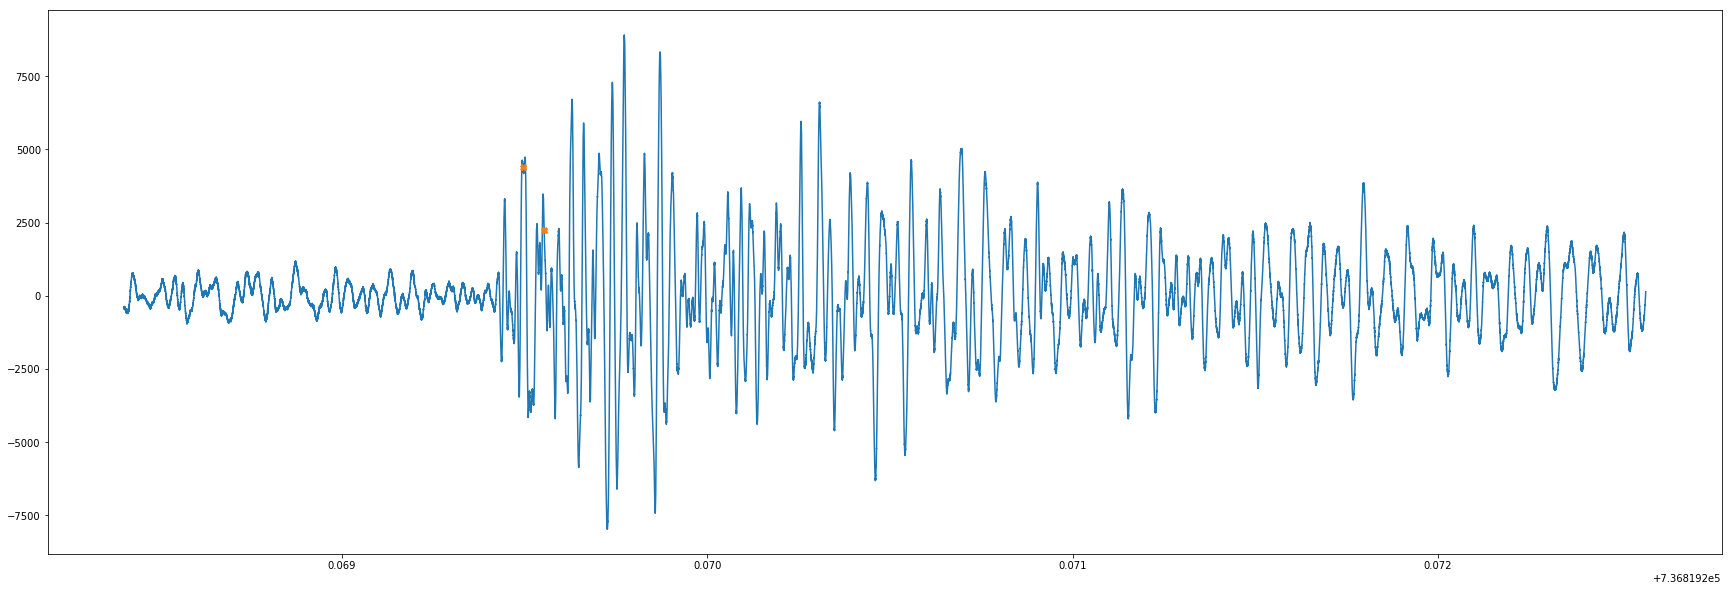

In [153]:
t1 = station_data[0]
t1_data = t1.data
t1_times = t1.times("utcdatetime")
starttime=UTCDateTime('2018-05-05T06:26:30')
endtime=UTCDateTime('2018-05-05T06:32:30')
ind_s = np.where(t1_times > starttime)
ind_e = np.where(t1_times < endtime)
indexes = np.intersect1d(ind_s, ind_e)
t1_matplotlib_times = t1.times("matplotlib")

inter = np.intersect1d(lpeaks, indexes)

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(t1_matplotlib_times[indexes], t1_data[indexes])
ax.plot(t1_matplotlib_times[inter], t1_data[inter], "X")
plt.show()